In [10]:
import pandas as pd
import numpy as np
from sklearn.cluster import AgglomerativeClustering
from sklearn.preprocessing import MinMaxScaler
from random import randint
import json

# Przygotowanie danych

In [11]:
def jsonl2df(path):
    with open(path) as fh:
        lines = fh.read().splitlines()

    df_inter = pd.DataFrame(lines)
    df_inter.columns = ['json_element']


    df_inter['json_element'].apply(json.loads)

    return pd.json_normalize(df_inter['json_element'].apply(json.loads))

artists = jsonl2df("datav2/artists.jsonl")
tracks = jsonl2df("datav2/tracks.jsonl")

In [12]:
# Choose data from ranking

# result = ['ranking', 'list', ...]

# tracks[tracks['id'].isin(result)]

In [66]:
# Join tracks with artists
begin_prepared_data = pd.merge(tracks,artists, left_on="id_artist", right_on="id")

# Remove rows with empty values
begin_prepared_data = begin_prepared_data.dropna()
begin_prepared_data = begin_prepared_data.drop(columns=["name_x", "popularity", "id_y", "name_y"])

prepared_data = begin_prepared_data

# Convert dates to number of days from earliest track
prepared_data["release_date"] = pd.to_datetime(prepared_data["release_date"], format = "mixed")
min_date = prepared_data['release_date'].min()
prepared_data['release_date'] = (prepared_data['release_date'] - min_date).dt.days

# Scale the attributes to [0, 1]
without = ['id_x', 'duration_ms', 'id_artist', 'genres']
scaled_columns = list(set(prepared_data.columns).difference(without))
prepared_data[scaled_columns] = MinMaxScaler().fit_transform(prepared_data[scaled_columns])

# One-hot encoding of genres
genres_en = pd.get_dummies(prepared_data['genres'].apply(pd.Series).stack()).groupby(level=0).sum()
prepared_data = pd.concat([prepared_data, genres_en], axis=1)

# One-hot encoding of artists
artists_en = pd.get_dummies(prepared_data['id_artist']).groupby(level=0).sum()
prepared_data = pd.concat([prepared_data, artists_en], axis=1)

prepared_data = prepared_data.drop(columns=['id_artist', 'genres'])

TODO
- Selekcja atrybutów
- Może ograniczyć gatunki i autorów sprawdzając czy występują minimalna liczbę razy, [Infrequent categories sklearn](https://scikit-learn.org/stable/modules/preprocessing.html#infrequent-categories)

In [14]:
TIME_LIMIT = 3600000

# Model podstawowy

- mieszamy kolejność dataframe
- dokładamy do obecnej grupy kolejne utwory dopóki ich suma nie przekroczy godziny
- jeżeli ostatnia grupa ma mniej niż godzinę to ją rozdzielamy pomiędzy pozostałe

In [15]:
def base_model(data: pd.DataFrame) -> pd.DataFrame:     # [track_id, group]
    track_times = data[['id_x', 'duration_ms']]

    # mieszanie wierszy
    track_times.sample(frac=1).reset_index(drop=True)
    current_group = 0
    group_sum = 0

    result = []

    for index, row in track_times.iterrows():
        result.append((row['id_x'], current_group))
        group_sum += row['duration_ms']
        if group_sum >= TIME_LIMIT:        # godzina
            group_sum = 0
            current_group += 1

    # ostatnia grupa mniej niż godzina
    if group_sum < TIME_LIMIT:
        for i in range(len(result)):
            if result[-1-i][1] == current_group:
                result[-1-i] = (result[-1-i][0], randint(0,current_group-1))
            else:
                break

    result_df = pd.DataFrame(result, columns=['id', 'group'])
    return result_df

# Model zaawansowany

- korzystamy z algorytmu AgglomerativeClustering
- na początku każdy utwór ma przypisany unikalną grupę oraz otrzymujemy które kolejne klastry mają być łaczone
- łączymy kolejne klastry dopóki wszystkie klastry nie posiadają sumy długości utworów o conajmniej godzinie
- na końcu jeżeli jakaś grupa nie ma godziny to jej nie zwracamy

In [16]:
def check_less(data, min_duration=TIME_LIMIT):
    result = []
    for group in data['group'].unique():
        group_data = data[data['group'] == group]
        if group_data['duration_ms'].sum() < min_duration:
            result.append(group)
    return result

In [17]:
def check_all_more_than_hour(data: pd.DataFrame):
    return all(data.groupby(by=['group'])['duration_ms'].sum() > TIME_LIMIT)

In [18]:
def merge_clusters(data):
    params = data.drop(columns=['duration_ms', 'id_x'])
    clustering = AgglomerativeClustering(n_clusters=None, distance_threshold=0).fit(params)
    # clustering = AgglomerativeClustering(n_clusters=3).fit(params)

    data.loc[:, 'group'] = clustering.labels_

    n_samples = data.shape[0]

    # sprawdzać też czy nie przekroczy dystansu
    for i, (cluster1, cluster2) in enumerate(clustering.children_): # children zawiera listę krotek które klastry się łączą
        data.loc[data['group'] == cluster1, 'group'] = n_samples + i
        data.loc[data['group'] == cluster2, 'group'] = n_samples + i
        if check_all_more_than_hour(data):
            return data

    return data

In [19]:
def advanced_model(data: pd.DataFrame) -> pd.DataFrame:     # [track_id, group]
    result = merge_clusters(data)

    less_hour = check_less(result)

    result = data[~data['group'].isin(less_hour)]

    return result[['id_x', 'group']]

TODO
- sprawdzenie parametrów algorytmu tj. metric, linkage, distance_threshold

# TESTOWANIE

In [55]:
import numpy as np
from matplotlib import pyplot as plt
from scipy.cluster.hierarchy import dendrogram

def plot_dendrogram(model, **kwargs):
    # Create linkage matrix and then plot the dendrogram

    # create the counts of samples under each node
    counts = np.zeros(model.children_.shape[0])
    n_samples = len(model.labels_)
    for i, merge in enumerate(model.children_):
        current_count = 0
        for child_idx in merge:
            if child_idx < n_samples:
                current_count += 1  # leaf node
            else:
                current_count += counts[child_idx - n_samples]
        counts[i] = current_count

    linkage_matrix = np.column_stack(
        [model.children_, model.distances_, counts]
    ).astype(float)

    # Plot the corresponding dendrogram
    dendrogram(linkage_matrix, **kwargs)

In [24]:
from sklearn.decomposition import PCA
from matplotlib import pyplot as plt


def pca_scatter(model, labels, title):
    pca = PCA(n_components=2)
    X_pca = pca.fit_transform(model)
    plt.scatter(X_pca[:, 0], X_pca[:, 1], c=labels, cmap='viridis')
    plt.title(title)
    plt.show()

In [42]:
test = prepared_data[:100]
params = test.drop(columns=['id_x', 'duration_ms'])

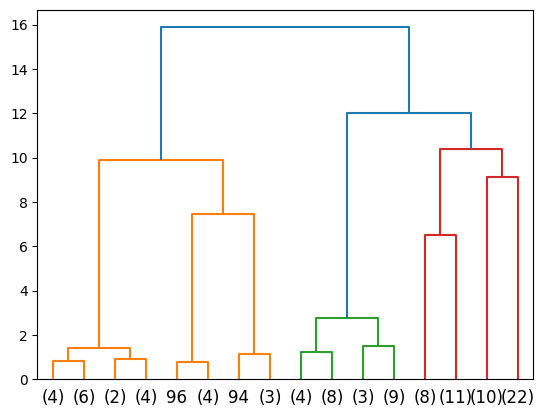

In [56]:
clustering = AgglomerativeClustering(distance_threshold=0, n_clusters=None).fit(params)

plot_dendrogram(clustering, truncate_mode="level", p=3)

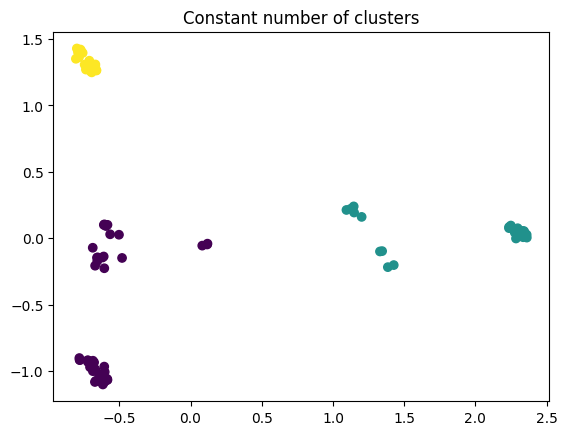

In [44]:
clustering = AgglomerativeClustering(n_clusters=3).fit(params)
labels = clustering.labels_
pca_scatter(params, labels, 'Constant number of clusters')

In [45]:
np.unique(labels, return_counts=True)

(array([0, 1, 2]), array([51, 25, 24]))

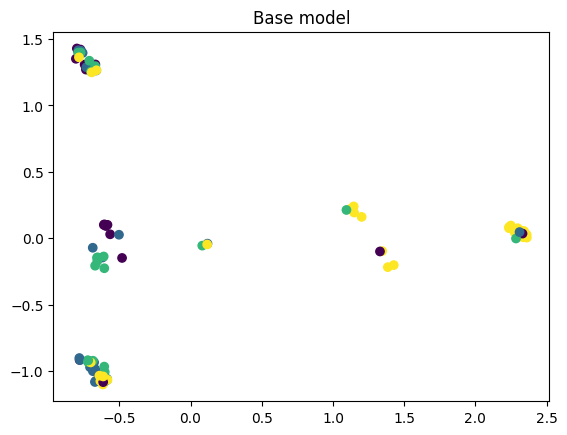

In [48]:
base = base_model(test)

labels = base['group']
pca_scatter(params, labels, 'Base model')

In [49]:
np.unique(labels, return_counts=True)

(array([0, 1, 2, 3]), array([22, 24, 24, 30]))

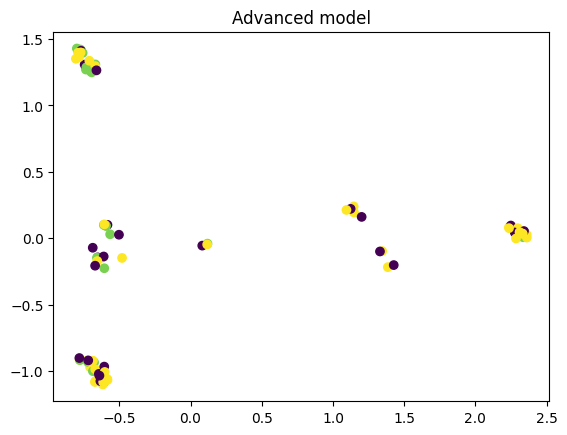

In [71]:
advanced = advanced_model(test)
labels = advanced['group']
pca_scatter(params, np.array(labels), 'Advanced model')

In [72]:
np.unique(labels, return_counts=True)

(array([191, 195, 196]), array([24, 25, 51]))

Sprawdzenie czy dane w grupie są podobne

In [80]:
group_id = labels[0]
result = advanced[advanced['group'] == 191]['id_x']

In [82]:
first_group = begin_prepared_data[begin_prepared_data['id_x'].isin(result)]
first_group

,id_x,duration_ms,explicit,id_artist,release_date,danceability,energy,key,loudness,speechiness,acousticness,instrumentalness,liveness,valence,tempo,genres
6,5DIVWgTeJ2fPIxaY9e7ZKn,196440,0.0,5V0MlUE1Bft0mbLlND7FJz,0.235090,0.464286,0.106014,0.181818,0.673089,0.044703,0.989960,0.000000,0.111675,0.260343,0.303532,"[adult standards, jazz blues, swing, vocal jazz]"
12,3YCbx1QqGrnxMsPEZLC1CT,162840,0.0,1Mxqyy3pSjf8kZZL4QVxS0,0.294374,0.558163,0.208127,0.818182,0.687028,0.035381,0.678714,0.000000,0.089340,0.427851,0.495227,"[adult standards, easy listening, lounge]"
24,3xW8q9WgpTGfHr78ZHb0d0,218293,0.0,1Mxqyy3pSjf8kZZL4QVxS0,0.303454,0.297959,0.076081,0.090909,0.526103,0.041208,0.849397,0.007806,0.091371,0.152371,0.577077,"[adult standards, easy listening, lounge]"
35,0kDpFPQgQYeZ7t04Quiwkn,249782,0.0,7G1GBhoKtEPnP86X2PvEYO,0.319447,0.486735,0.049351,0.363636,0.516137,0.069068,0.959839,0.000002,0.098477,0.196771,0.283663,"[adult standards, jazz blues, soul, soul jazz,..."
38,0SIzIfR6913S1oqTbyg8YC,226360,0.0,5V0MlUE1Bft0mbLlND7FJz,0.325114,0.623469,0.285212,0.000000,0.758790,0.072246,0.840361,0.000000,0.091371,0.609485,0.361033,"[adult standards, jazz blues, swing, vocal jazz]"
39,0GvhHQbWSnGltjl0je61dI,144947,0.0,43ZHCT0cAZBISjO8DG9PnE,0.325767,0.713265,0.514464,0.363636,0.705851,0.033369,0.589357,0.029058,0.211168,0.635721,0.548653,"[adult standards, rock-and-roll, rockabilly]"
42,0KSHmjK7OFtGocvbo7NZNO,107280,0.0,6kACVPfCOnqzgfEF5ryl0x,0.332324,0.769388,0.484431,0.909091,0.781630,0.064513,0.806225,0.000009,0.088223,0.808274,0.376017,"[arkansas country, outlaw country]"
43,4Hhv2vrOTy89HFRcjU3QOx,179693,0.0,0iOVhN3tnSvgDbcg25JoJb,0.335944,0.279592,0.348281,0.454545,0.794171,0.031038,0.549196,0.013327,0.326904,0.330979,0.397230,"[adult standards, jazz blues, soul, soul blues..."
46,4yjz1aazw6R8ZURpGbCAkp,165280,0.0,6hnWRPzGGKiapVX1UCdEAC,0.335944,0.491837,0.569525,0.000000,0.854857,0.034746,0.619477,0.000000,0.145178,0.614531,0.321869,"[adult standards, brill building pop, classic ..."
49,2IdwQxhJn9ZE4zIotcCefR,187667,0.0,0iOVhN3tnSvgDbcg25JoJb,0.335944,0.267347,0.356290,0.000000,0.807489,0.032097,0.615461,0.000000,0.165482,0.429869,0.791353,"[adult standards, jazz blues, soul, soul blues..."


In [83]:
first_group.describe()

,duration_ms,explicit,release_date,danceability,energy,key,loudness,speechiness,acousticness,instrumentalness,liveness,valence,tempo
count,24.000000,24.0,24.000000,24.000000,24.000000,24.000000,24.000000,24.000000,24.000000,24.000000,24.000000,24.000000,24.000000
mean,179407.541667,0.0,0.346673,0.493282,0.389564,0.409091,0.721871,0.044765,0.690763,0.002163,0.178029,0.569753,0.493228
std,65172.595613,0.0,0.034967,0.152457,0.216194,0.313775,0.097959,0.014873,0.213965,0.006500,0.126749,0.253001,0.166663
min,107280.000000,0.0,0.235090,0.184694,0.049351,0.000000,0.516137,0.028072,0.184738,0.000000,0.053198,0.152371,0.283663
25%,141179.750000,0.0,0.330685,0.381378,0.256930,0.159091,0.683543,0.034719,0.605170,0.000000,0.091371,0.360494,0.360649
50%,164060.000000,0.0,0.366195,0.497959,0.367302,0.363636,0.728525,0.039195,0.715863,0.000001,0.118274,0.612008,0.481340
75%,194679.750000,0.0,0.372797,0.589031,0.513714,0.636364,0.784765,0.052913,0.842620,0.000062,0.224112,0.762361,0.582332
max,412200.000000,0.0,0.378108,0.769388,0.854840,1.000000,0.854857,0.085381,0.989960,0.029058,0.572589,0.973764,0.809204


# Wnioski 
## model zaawansowany:
- tracimy część danych podczas ostatniego kroku bo nie będą one zwracane
- powinniśmy ustawić dodatkowo distance_threshold aby algorytm nie łączył niepotrzebnie klastrów. Dobrze widoczne jest to na dendogramie, gdy mało liczna grupa, która jeszcze nie spełniła warunku czasowego ma wysoki dystans do kolejnego połączenia. Aktualnie tracimy przez to podobieństwo danych w danej grupie.